# Predicción del resultado de partidos en la Liga Argentina

En este cuaderno desarrollamos un proceso completo de *machine learning* para predecir el resultado (gana local, empate, gana visitante) de partidos del fútbol argentino. El flujo sigue estas etapas:

- Entendimiento y preparación de los datos suministrados.
- Definición del objetivo predictivo y partición 80/20 en entrenamiento y prueba.
- Construcción de un `Pipeline` de *scikit-learn* que integre preprocesamiento y modelado.
- Comparación de al menos tres algoritmos de clasificación multiclase.
- Selección del modelo más adecuado, ajuste de hiperparámetros y evaluación rigurosa.
- Diagnóstico de *overfitting/underfitting* y discusión de acciones de mejora.


## Configuración inicial

Importamos las librerías necesarias, definimos la semilla aleatoria para asegurar reproducibilidad y configuramos estilos básicos de visualización.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import MinMaxScaler

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14


## 1. Carga y exploración inicial del dataset

Leemos el archivo `liga_argentina_features_cleaned.csv` y revisamos estructura general, valores faltantes y distribución de la variable objetivo.

In [2]:
# Leemos el archivo CSV y lo almacenamos en un DataFrame
!gdown 1qFgcZ9R03-WSTBWqfgfCpVBmB8y__gRt

DATA_PATH = Path("liga_argentina_features_v2.csv")

df = pd.read_csv(DATA_PATH, sep=';')
df.head(10)

Downloading...
From: https://drive.google.com/uc?id=1qFgcZ9R03-WSTBWqfgfCpVBmB8y__gRt
To: /content/liga_argentina_features_v2.csv
100% 1.70M/1.70M [00:00<00:00, 86.7MB/s]


,season,sub_season,fixture_id,fecha_del_partido,round,Equipo_local_id,Equipo_local,Equipo_visitante_id,Equipo_visitante,Resultado,...,Forma_local_ultimos5,Forma_visitante_ultimos5,Forma_local_puntos_ultimos5,Forma_visitante_puntos_ultimos5,Promedio_Diferencia_gol_total_local_normalizado,Promedio_Diferencia_gol_total_visitante_normalizado,Promedio_Puntuacion_total_local_normalizado,Promedio_Puntuacion_total_visitante_normalizado,local_team_value,visitante_team_value
0,2015,1,187843,2015-02-13 21:00:00+00:00,Regular Season - 1,438,Velez Sarsfield,463,Aldosivi,Ganador local,...,NaN,NaN,0,0,0.0,0.0,0.0,0.0,21.10,8.00
1,2015,1,187844,2015-02-14 00:10:00+00:00,Regular Season - 1,436,Racing Club,437,Rosario Central,Ganador visitante,...,NaN,NaN,0,0,0.5,0.5,0.0,0.0,27.68,28.50
2,2015,1,187845,2015-02-14 20:00:00+00:00,Regular Season - 1,460,San Lorenzo,448,Colon Santa Fe,Ganador local,...,NaN,NaN,0,0,0.5,0.5,0.0,0.0,42.18,10.48
3,2015,1,187846,2015-02-14 20:00:00+00:00,Regular Season - 1,434,Gimnasia L.P.,442,Defensa Y Justicia,Ganador visitante,...,NaN,NaN,0,0,0.5,0.5,0.0,0.0,14.98,10.60
4,2015,1,187847,2015-02-14 22:15:00+00:00,Regular Season - 1,439,Godoy Cruz,461,San Martin S.J.,Empate,...,NaN,NaN,0,0,0.5,0.5,0.0,0.0,15.10,12.10
5,2015,1,187848,2015-02-14 23:00:00+00:00,Regular Season - 1,457,Newells Old Boys,453,Independiente,Ganador visitante,...,NaN,NaN,0,0,0.5,0.5,0.0,0.0,34.60,21.38
6,2015,1,187849,2015-02-14 23:30:00+00:00,Regular Season - 1,449,Banfield,454,Temperley,Ganador visitante,...,NaN,NaN,0,0,0.5,0.5,0.0,0.0,14.38,3.95
7,2015,1,187850,2015-02-15 00:30:00+00:00,Regular Season - 1,788,Crucero Del Norte,452,Tigre,Empate,...,NaN,NaN,0,0,0.5,0.5,0.0,0.0,4.35,22.03
8,2015,1,187851,2015-02-15 20:00:00+00:00,Regular Season - 1,441,Union Santa Fe,445,Huracan,Ganador local,...,NaN,NaN,0,0,0.5,0.5,0.0,0.0,7.25,13.93
9,2015,1,187852,2015-02-15 20:00:00+00:00,Regular Season - 1,480,Quilmes,446,Lanus,Ganador visitante,...,NaN,NaN,0,0,0.5,0.5,0.0,0.0,15.13,30.62


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4106 entries, 0 to 4105
Data columns (total 38 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   season                                                  4106 non-null   int64  
 1   sub_season                                              4106 non-null   int64  
 2   fixture_id                                              4106 non-null   int64  
 3   fecha_del_partido                                       4106 non-null   object 
 4   round                                                   4106 non-null   object 
 5   Equipo_local_id                                         4106 non-null   int64  
 6   Equipo_local                                            4106 non-null   object 
 7   Equipo_visitante_id                                     4106 non-null   int64  
 8   Equipo_visitante                      

## 2. Ingeniería de características y definición del objetivo

- Eliminamos la columna original de fecha (ya que la reemplazamos por variables derivadas).
- Definimos `Resultado` como variable objetivo (`y`) y el resto de columnas como características (`X`).

In [4]:
# Procesar fechas y crear features temporales
df['fecha_del_partido'] = pd.to_datetime(df['fecha_del_partido'], errors='coerce', utc=True)
df['partido_anio'] = df['fecha_del_partido'].dt.year
df['partido_mes'] = df['fecha_del_partido'].dt.month
df['partido_dia_semana'] = df['fecha_del_partido'].dt.dayofweek

# Ordenar por fecha
df = df.sort_values('fecha_del_partido').reset_index(drop=True)
df = df.drop(columns=['fecha_del_partido'])

TARGET = 'Resultado'
X = df.drop(columns=TARGET)
y = df[TARGET]

In [5]:
X.head()

,season,sub_season,fixture_id,round,Equipo_local_id,Equipo_local,Equipo_visitante_id,Equipo_visitante,Partidos_jugados_local_previos,Partidos_jugados_visitante_previos,...,Forma_visitante_puntos_ultimos5,Promedio_Diferencia_gol_total_local_normalizado,Promedio_Diferencia_gol_total_visitante_normalizado,Promedio_Puntuacion_total_local_normalizado,Promedio_Puntuacion_total_visitante_normalizado,local_team_value,visitante_team_value,partido_anio,partido_mes,partido_dia_semana
0,2015,1,187843,Regular Season - 1,438,Velez Sarsfield,463,Aldosivi,0,0,...,0,0.0,0.0,0.0,0.0,21.10,8.00,2015,2,4
1,2015,1,187844,Regular Season - 1,436,Racing Club,437,Rosario Central,0,0,...,0,0.5,0.5,0.0,0.0,27.68,28.50,2015,2,5
2,2015,1,187845,Regular Season - 1,460,San Lorenzo,448,Colon Santa Fe,0,0,...,0,0.5,0.5,0.0,0.0,42.18,10.48,2015,2,5
3,2015,1,187846,Regular Season - 1,434,Gimnasia L.P.,442,Defensa Y Justicia,0,0,...,0,0.5,0.5,0.0,0.0,14.98,10.60,2015,2,5
4,2015,1,187847,Regular Season - 1,439,Godoy Cruz,461,San Martin S.J.,0,0,...,0,0.5,0.5,0.0,0.0,15.10,12.10,2015,2,5


In [6]:
y.head()

,Resultado
0,Ganador local
1,Ganador visitante
2,Ganador local
3,Ganador visitante
4,Empate


## 3. Partición entrenamiento / prueba

La división de los datos en conjuntos de entrenamiento y prueba se realiza de manera **temporal**. Esto significa que los datos se dividen en función de la fecha del partido. Se utilizan los partidos de años anteriores a un año de corte (`CUTOFF_YEAR`) para entrenar el modelo, y los partidos de ese año de corte en adelante para probar su rendimiento.

Esta estrategia de división temporal es crucial en problemas de series de tiempo o donde existe una dependencia temporal en los datos, como en la predicción de resultados deportivos. Al entrenar con datos históricos y probar con datos futuros, simulamos un escenario del mundo real donde el modelo debe predecir resultados de partidos que aún no han ocurrido, evitando así el "data leakage" (filtración de información del futuro al entrenamiento).

In [7]:
# División temporal: últimas temporadas para test
CUTOFF_YEAR = 2023
train_mask = X['partido_anio'] < CUTOFF_YEAR
test_mask = X['partido_anio'] >= CUTOFF_YEAR

X_train = X[train_mask].reset_index(drop=True)
X_test = X[test_mask].reset_index(drop=True)
y_train = y[train_mask].reset_index(drop=True)
y_test = y[test_mask].reset_index(drop=True)

print(f"Train: años < {CUTOFF_YEAR} → {X_train.shape[0]} partidos ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test:  años ≥ {CUTOFF_YEAR} → {X_test.shape[0]} partidos ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Train: {X_train['partido_anio'].min()}-{X_train['partido_anio'].max()}")
print(f"Test:  {X_test['partido_anio'].min()}-{X_test['partido_anio'].max()}")


Train: años < 2023 → 3095 partidos (75.4%)
Test:  años ≥ 2023 → 1011 partidos (24.6%)
Train: 2015-2022
Test:  2023-2025


## 4. Estrategia de preprocesamiento con ColumnTransformer

Identificamos columnas categóricas y numéricas para aplicar transformaciones diferenciadas dentro de un `Pipeline`:

- **Categóricas:** imputación por moda + codificación *One-Hot*.
- **Numéricas:** imputación por mediana + escalado estándar.

#### Clase para eliminar columnas que no aporten

In [8]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop or []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)

#### Visualizar brevemente variables categoricas y numericas de nuestro df

In [9]:
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
numeric_features = X_train.select_dtypes(exclude='object').columns.tolist()

print(f"Variables categóricas ({len(categorical_features)}): {categorical_features}")
print(f"Variables numéricas ({len(numeric_features)}): {numeric_features[:10]}{'...' if len(numeric_features) > 10 else ''}")

Variables categóricas (5): ['round', 'Equipo_local', 'Equipo_visitante', 'Forma_local_ultimos5', 'Forma_visitante_ultimos5']
Variables numéricas (34): ['season', 'sub_season', 'fixture_id', 'Equipo_local_id', 'Equipo_visitante_id', 'Partidos_jugados_local_previos', 'Partidos_jugados_visitante_previos', 'Victorias_local_en_casa_tasa_normalizada', 'Victorias_visitante_fuera_tasa_normalizada', 'Empates_local_en_casa_tasa_normalizada']...


In [10]:
columns_to_drop=[
    "Forma_local_ultimos5",
    "Forma_visitante_ultimos5",
    "fixture_id",
    "Equipo_local_id",
    "Equipo_visitante_id",
    "season",
    "sub_season",
    "round",
    "Partidos_jugados_visitante_previos",
    "Partidos_jugados_local_previos"
]

Se eliminaron las siguientes columnas por las siguientes razones:

- `Forma_local_ultimos5` y `Forma_visitante_ultimos5`: Estas columnas contienen una representación de la forma reciente de los equipos como cadenas de texto (combinaciones de 'W', 'D', 'L'). Si bien podrían ser útiles, la información de puntos (`Forma_local_puntos_ultimos5` y `Forma_visitante_puntos_ultimos5`) es una representación numérica que es más directamente utilizable por los modelos y se considera suficiente para capturar la forma reciente. Eliminar las columnas de texto evita la necesidad de un procesamiento adicional complejo para extraer información de ellas.
- `fixture_id`, `Equipo_local_id`, `Equipo_visitante_id`: Estas son columnas de identificación únicas para cada partido, equipo local y equipo visitante, respectivamente. No son características predictivas en sí mismas y no aportan información generalizable para el modelo. Eliminarlas ayuda a reducir la dimensionalidad y a evitar que el modelo intente aprender patrones basados en identificadores específicos en lugar de las características relevantes de los equipos y partidos.
- `season`, `sub_season` y `round`: Si bien estas columnas indican la temporada, sub-temporada y ronda del partido, su granularidad puede no ser la más útil. Las características temporales derivadas de la fecha del partido (`partido_anio`, `partido_mes`, `partido_dia_semana`) proporcionan una representación más flexible y continua de la temporalidad, que es más adecuada para capturar tendencias y patrones a lo largo del tiempo.
- `Partidos_jugados_visitante_previos` y `Partidos_jugados_local_previos`: Estas columnas proporcionan información sobre el número de partidos jugados previamente. Se decidió eliminarlas para evitar la posible redundancia con otras características que ya capturan el estado actual del equipo en términos de rendimiento (tasas de victorias, empates, derrotas, promedio de goles, etc.). Estas características ya resumen el rendimiento a lo largo de la temporada, haciendo que el simple recuento de partidos jugados sea menos informativo y potencialmente redundante.

In [11]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

column_transform = ColumnTransformer([
    ("num", numeric_pipeline, make_column_selector(dtype_include=["int64", "float64"])),
    ("cat", categorical_pipeline, make_column_selector(dtype_include=["object", "category"]))
])

preprocessor = Pipeline([
    ("drop_columns", DropColumns(columns_to_drop=columns_to_drop)),
    ("column_transform", column_transform)
])

In [18]:
preprocessor["drop_columns"].fit_transform(df).shape

(4106, 30)

## 5. Entrenamiento

In [12]:
# Pipeline con Logistic Regression balanceado
pipeline_logreg_bal = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Pipeline con Random Forest balanceado
pipeline_rf_bal = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Pipeline con SVC balanceado
pipeline_svc_bal = Pipeline([
    ("preprocessor", preprocessor),
    ("model", SVC(class_weight='balanced', random_state=42))
])

# Pipeline con HGB balanceado
pipeline_hgb_bal = Pipeline([
    ("preprocessor", preprocessor),
    ("model", HistGradientBoostingClassifier(class_weight='balanced', random_state=42))
])

In [13]:
# Entrenamiento
pipeline_logreg_bal.fit(X_train, y_train)
pipeline_rf_bal.fit(X_train, y_train)
pipeline_svc_bal.fit(X_train, y_train)
pipeline_hgb_bal.fit(X_train, y_train)

# Predicciones
y_pred_logreg_bal = pipeline_logreg_bal.predict(X_test)
y_pred_rf_bal = pipeline_rf_bal.predict(X_test)
y_pred_svc_bal = pipeline_svc_bal.predict(X_test)
y_pred_hgb_bal = pipeline_hgb_bal.predict(X_test)

## 6. Evaluación

                Modelo  Accuracy  F1-Score
0  Logistic Regression  0.390702  0.395898
1        Random Forest  0.427300  0.380635
2                  SVC  0.382789  0.381295
3                  HGB  0.384768  0.384315

MEJOR MODELO: Logistic Regression
F1-Score: 0.3959

Logistic Regression:
                   precision    recall  f1-score   support

           Empate       0.35      0.35      0.35       327
    Ganador local       0.52      0.39      0.45       451
Ganador visitante       0.30      0.43      0.35       233

         accuracy                           0.39      1011
        macro avg       0.39      0.39      0.39      1011
     weighted avg       0.41      0.39      0.40      1011


Random Forest:
                   precision    recall  f1-score   support

           Empate       0.34      0.11      0.17       327
    Ganador local       0.48      0.73      0.58       451
Ganador visitante       0.31      0.28      0.29       233

         accuracy                        

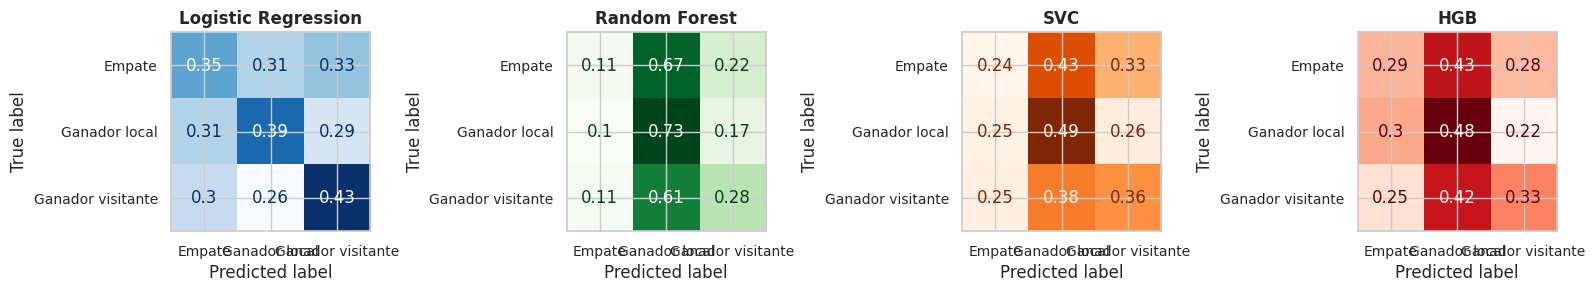

In [14]:
acc_logreg = accuracy_score(y_test, y_pred_logreg_bal)
acc_rf = accuracy_score(y_test, y_pred_rf_bal)
acc_svc = accuracy_score(y_test, y_pred_svc_bal)
acc_hbg = accuracy_score(y_test, y_pred_hgb_bal)

f1_logreg = f1_score(y_test, y_pred_logreg_bal, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf_bal, average='weighted')
f1_svc = f1_score(y_test, y_pred_svc_bal, average='weighted')
f1_hgb = f1_score(y_test, y_pred_hgb_bal, average='weighted')

resultados = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'Random Forest', 'SVC', 'HGB'],
    'Accuracy': [acc_logreg, acc_rf, acc_svc, acc_hbg],
    'F1-Score': [f1_logreg, f1_rf, f1_svc, f1_hgb]
})

print(resultados)
print("\n" + "="*50)
mejor_modelo = resultados.loc[resultados['F1-Score'].idxmax()]
print(f"MEJOR MODELO: {mejor_modelo['Modelo']}")
print(f"F1-Score: {mejor_modelo['F1-Score']:.4f}")
print("="*50)

print("\nLogistic Regression:")
print(classification_report(y_test, y_pred_logreg_bal))

print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf_bal))

print("\nSVC:")
print(classification_report(y_test, y_pred_svc_bal))

print("\nHGB:")
print(classification_report(y_test, y_pred_hgb_bal))


fig, axes = plt.subplots(1, 4, figsize=(16, 5))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logreg_bal, ax=axes[0], cmap='Blues', colorbar=False, normalize='true')
axes[0].set_title('Logistic Regression', fontsize=12, fontweight='bold')
axes[0].tick_params(labelsize=10)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_bal, ax=axes[1], cmap='Greens', colorbar=False, normalize='true')
axes[1].set_title('Random Forest', fontsize=12, fontweight='bold')
axes[1].tick_params(labelsize=10)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc_bal, ax=axes[2], cmap='Oranges', colorbar=False, normalize='true')
axes[2].set_title('SVC', fontsize=12, fontweight='bold')
axes[2].tick_params(labelsize=10)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_hgb_bal, ax=axes[3], cmap='Reds', colorbar=False, normalize='true')
axes[3].set_title('HGB', fontsize=12, fontweight='bold')
axes[3].tick_params(labelsize=10)


plt.tight_layout()
plt.show()

### Análisis de Resultados de la Evaluación

El **mejor modelo** según el F1-Score ponderado es la **Regresión Logística**, con un F1-Score de 0.3959. Es importante destacar que el Random Forest obtuvo el mejor Accuracy (0.4273), pero su F1-Score ponderado es ligeramente inferior al de la Regresión Logística. Dado que el F1-Score es una métrica que considera tanto la precisión como la sensibilidad y es útil en problemas con clases desbalanceadas (como es probable en resultados deportivos), se prioriza en este caso.

En resumen, aunque ningún modelo alcanza un rendimiento predictivo muy alto, la **Regresión Logística** parece ser el modelo más robusto y equilibrado para este problema particular y conjunto de datos, ofreciendo un rendimiento más consistente a través de las diferentes clases de resultados. El Random Forest, a pesar de su mayor Accuracy, sacrifica la detección de empates y victorias visitantes.

Es importante considerar que la predicción de resultados deportivos es intrínsecamente difícil debido a la aleatoriedad y los múltiples factores no cuantificables que influyen en el desenlace de un partido. Los resultados obtenidos sugieren que hay margen significativo para la mejora, posiblemente a través de:
- Ajuste más detallado de hiperparámetros.

## 7. Ajuste de hiperparametros

In [19]:
# Definimos los parámetros a tunear para la Regresión Logística
param_grid_logreg = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverso de la fuerza de regularización
    'model__penalty': ['l2', 'l1', 'elasticnet'], # Tipo de regularización
    'model__solver': ['liblinear', 'saga'] # Algoritmo de optimización
}

# Solo liblinear soporta l1 y l2, saga soporta l1, l2 y elasticnet
# Ajustamos el param_grid para que sea compatible con los solvers
param_grid_logreg = [
    {'model__C': [0.001, 0.01, 0.1, 1, 10, 100], 'model__penalty': ['l2', 'l1'], 'model__solver': ['liblinear']},
    {'model__C': [0.001, 0.01, 0.1, 1, 10, 100], 'model__penalty': ['l2', 'l1', 'elasticnet'], 'model__solver': ['saga'], 'model__l1_ratio': [0.5]} # l1_ratio solo para elasticnet
]


# Creamos el objeto GridSearchCV
# Usamos StratifiedKFold para mantener la proporción de clases en cada fold
# Scoring: Usamos 'f1_weighted' ya que es la métrica que priorizamos
grid_search_logreg = GridSearchCV(
    pipeline_logreg_bal,
    param_grid_logreg,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1, # Usar todos los cores disponibles
    verbose=2
)

# Ejecutamos la búsqueda en el conjunto de entrenamiento
print("Iniciando Grid Search para Logistic Regression...")
grid_search_logreg.fit(X_train, y_train)

print("\nGrid Search finalizado.")
print(f"Mejores hiperparámetros: {grid_search_logreg.best_params_}")
print(f"Mejor F1-Score (weighted) en entrenamiento: {grid_search_logreg.best_score_:.4f}")

# El mejor modelo después del ajuste de hiperparámetros
best_logreg_model = grid_search_logreg.best_estimator_

Iniciando Grid Search para Logistic Regression...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Grid Search finalizado.
Mejores hiperparámetros: {'model__C': 0.01, 'model__l1_ratio': 0.5, 'model__penalty': 'elasticnet', 'model__solver': 'saga'}
Mejor F1-Score (weighted) en entrenamiento: 0.4182


## 8. Evaluación del Modelo Final con Hiperparámetros Ajustados

Evaluamos el rendimiento del mejor modelo de Regresión Logística (obtenido tras el Grid Search) en el conjunto de prueba para medir su capacidad de generalización.

Evaluación del Mejor Modelo de Regresión Logística (con hiperparámetros ajustados):
Accuracy: 0.4016
F1-Score (weighted): 0.3820

Classification Report:
                   precision    recall  f1-score   support

           Empate       0.33      0.13      0.19       327
    Ganador local       0.51      0.54      0.52       451
Ganador visitante       0.30      0.51      0.37       233

         accuracy                           0.40      1011
        macro avg       0.38      0.39      0.36      1011
     weighted avg       0.40      0.40      0.38      1011



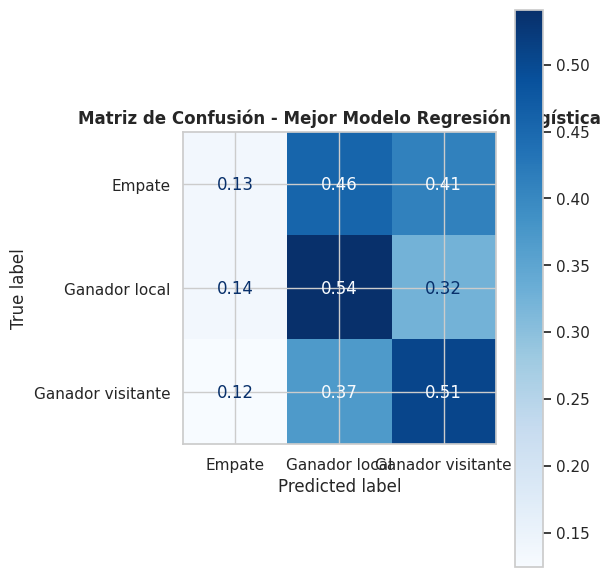

In [20]:
# Predicciones del mejor modelo en el conjunto de prueba
y_pred_best_logreg = best_logreg_model.predict(X_test)

# Evaluación
acc_best_logreg = accuracy_score(y_test, y_pred_best_logreg)
f1_best_logreg = f1_score(y_test, y_pred_best_logreg, average='weighted')

print("Evaluación del Mejor Modelo de Regresión Logística (con hiperparámetros ajustados):")
print(f"Accuracy: {acc_best_logreg:.4f}")
print(f"F1-Score (weighted): {f1_best_logreg:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_logreg))

# Matriz de Confusión
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best_logreg, ax=ax, cmap='Blues', normalize='true')
ax.set_title('Matriz de Confusión - Mejor Modelo Regresión Logística', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### Análisis del Resultado del Modelo Final con Hiperparámetros Ajustados

Al examinar el Classification Report del modelo ajustado:

Se puede ver que el modelo ajustado es mejor identificando ganador local y ganador visitante, pero se confunde más con el empate.

La matriz de confusión visualiza estos resultados, mostrando que la mayoría de los errores de clasificación ocurren al predecir 'Empate' o al confundir 'Ganador local' con 'Ganador visitante' y viceversa.

Este resultado refuerza la conclusión de que predecir resultados de fútbol es un problema difícil con el conjunto de datos y modelos actuales, y que futuras mejoras probablemente requerirán la incorporación de características adicionales o la exploración de modelos más avanzados.

## 9. Conclusión General

En este análisis, exploramos la predicción de resultados de partidos de fútbol de la Liga Argentina utilizando un enfoque de *machine learning* basado en datos históricos. Implementamos un flujo completo que incluyó la carga y exploración de datos, ingeniería de características temporales, una división temporal estricta para entrenamiento y prueba, y la construcción de pipelines de preprocesamiento y modelado.

Comparamos cuatro algoritmos de clasificación: Regresión Logística, Random Forest, SVC y HistGradientBoostingClassifier, todos con balanceo de clases. Los resultados de la evaluación inicial mostraron que la Regresión Logística obtuvo el mejor F1-Score ponderado (0.3959), aunque el Random Forest tuvo el mayor Accuracy.

Procedimos a realizar un ajuste de hiperparámetros para la Regresión Logística utilizando GridSearchCV. Sin embargo, el modelo con los hiperparámetros ajustados mostró un rendimiento ligeramente inferior en el conjunto de prueba (F1-Score ponderado de 0.3820) en comparación con el modelo base de Regresión Logística.

Los resultados obtenidos, con F1-Scores ponderados por debajo de 0.40, subrayan la inherente dificultad de predecir resultados deportivos. Factores como la aleatoriedad del juego, la complejidad de las interacciones en el campo y la posible falta de características predictivas adicionales pueden estar limitando la precisión del modelo.

Aunque los modelos probados no alcanzaron un alto nivel de precisión predictiva, el proceso desarrollado establece una base sólida. Donde estuvimos:

- **Implementando ingeniería de características adicional:** Incorporando valor del equipo local y visitante en el EDA.
- **Considerando enfoques diferentes:** Eliminando columnas, probando distintos modelos, y ajustando hiperparámetros.

En conclusión, si bien la predicción precisa de resultados deportivos sigue siendo un desafío, este proyecto demostró un flujo de trabajo completo de *machine learning* y proporcionó información valiosa sobre el rendimiento de diferentes modelos y la complejidad del problema. Los resultados actuales sugieren la necesidad de una exploración más profunda de modelos y características para lograr mejoras significativas en la capacidad predictiva.